# Environment

In [8]:
import pandas as pd
import numpy as np
from intervaltree import IntervalTree
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import os

# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

import importlib
import functions
importlib.reload(functions)
from functions import *

Current working directory: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords


In [9]:
# Example usage
peaks_file = "./DATA/Peak.csv"
dexseq_file = "./output_v38/dexseq_results_PW1_vs_combined_controls.csv"
output_prefix = "./output_v38/overlap_analysis"

# Load and process data

In [10]:
# Load and process data
peaks_df, dexseq_df = load_and_process_data(peaks_file, dexseq_file)

In [11]:
pd.set_option('display.max_columns', None)
peaks_df.head()

,Row.names,seqnames,start,end,width,annotation,geneChr,geneStart,geneEnd,geneLength,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,ASE1,ASE2,GeneID,Ctrl.bam,V5.bam,difference,FC,L2FC
0,chr15:25051475-25051745,chr15,25051475.0,25051745.0,271.0,Promoter (<=1kb),15.0,25051477.0,25051571.0,95.0,100033413.0,ENST00000384335.1,0.0,ENSG00000207063,SNORD116-1,"small nucleolar RNA, C/D box 116-1",NaN,NaN,controlledV5_peak_329,0,961,961,961.0,9.908392621
1,chr2:74154059-74154316,chr2,74154059.0,74154316.0,258.0,3' UTR,2.0,74148079.0,74151952.0,3874.0,100507171.0,ENST00000656407.1,5980.0,ENSG00000225439,BOLA3-DT,BOLA3 divergent transcript,NaN,NaN,controlledV5_peak_575,0,31,31,31.0,4.95419631
2,chr17:21198291-21198758,chr17,21198291.0,21198758.0,468.0,3' UTR,17.0,21184385.0,21193265.0,8881.0,25979.0,ENST00000581463.1,13906.0,ENSG00000109016,DHRS7B,dehydrogenase/reductase 7B,NaN,NaN,controlledV5_peak_423,0,20,20,20.0,4.321928095
3,chr17:744815-745029,chr17,744815.0,745029.0,215.0,3' UTR,17.0,747844.0,752038.0,4195.0,50628.0,ENST00000574958.1,7009.0,ENSG00000179409,GEMIN4,gem nuclear organelle associated protein 4,NaN,NaN,controlledV5_peak_403,0,18,18,18.0,4.169925001
4,chr10:27134830-27135032,chr10,27134830.0,27135032.0,203.0,Promoter (1-2kb),10.0,27123547.0,27136337.0,12791.0,10730.0,ENST00000463270.1,1305.0,ENSG00000136758,YME1L1,YME1 like 1 ATPase,NaN,NaN,controlledV5_peak_142,0,17,17,17.0,4.087462841


In [12]:
peaks_df = peaks_df.rename(columns={"Row.names": "peak_name"})

In [13]:
print(list(peaks_df['seqnames'][:5]))
print(list(peaks_df.iloc[:5].index))

['chr15', 'chr2', 'chr17', 'chr17', 'chr10']
[0, 1, 2, 3, 4]


In [14]:
dexseq_df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.15:E001,ENSG00000000003.15,E001,9.064419,0.016163,3928.904378,0.000000e+00,0.000000e+00,5.931265,5.009454,-0.513830,chrX,100627108,100627108,1,-,10,12,6,2,10,8,12,10,14
1,ENSG00000000003.15:E002,ENSG00000000003.15,E002,1364.225638,0.007380,465.843450,6.972364e-102,8.791361e-102,31.857029,31.513293,-0.075000,chrX,100627109,100629986,2878,-,1106,1345,750,970,1266,1057,1521,2781,2375
2,ENSG00000000003.15:E003,ENSG00000000003.15,E003,443.805530,0.009201,1962.650578,0.000000e+00,0.000000e+00,24.503872,24.252599,-0.056804,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.15:E004,ENSG00000000003.15,E004,1.978581,0.020921,3476.876104,0.000000e+00,0.000000e+00,2.634388,2.801898,0.180282,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.15:E005,ENSG00000000003.15,E005,330.134019,0.007735,2830.512068,0.000000e+00,0.000000e+00,22.609421,22.418042,-0.044010,chrX,100632485,100632540,56,-,269,321,184,215,299,267,354,675,613


In [15]:
dexseq_df = dexseq_df.rename(columns={"Unnamed: 0": "dexseq_name"})

In [16]:
dexseq_df.columns

Index(['dexseq_name', 'groupID', 'featureID', 'exonBaseMean', 'dispersion',
       'stat', 'pvalue', 'padj', 'control', 'treated',
       'log2fold_treated_control', 'genomicData.seqnames', 'genomicData.start',
       'genomicData.end', 'genomicData.width', 'genomicData.strand',
       'countData.EDO_1', 'countData.EDO_2', 'countData.EDO_3',
       'countData.ND1_1', 'countData.ND1_2', 'countData.ND1_3',
       'countData.PW1_1', 'countData.PW1_2', 'countData.PW1_3'],
      dtype='object')

In [17]:
print(list(dexseq_df['genomicData.seqnames'][:5]))
print(list(dexseq_df['featureID'][:5]))


['chrX', 'chrX', 'chrX', 'chrX', 'chrX']
['E001', 'E002', 'E003', 'E004', 'E005']


In [18]:
dexseq_df.head()

,dexseq_name,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.15:E001,ENSG00000000003.15,E001,9.064419,0.016163,3928.904378,0.000000e+00,0.000000e+00,5.931265,5.009454,-0.513830,chrX,100627108,100627108,1,-,10,12,6,2,10,8,12,10,14
1,ENSG00000000003.15:E002,ENSG00000000003.15,E002,1364.225638,0.007380,465.843450,6.972364e-102,8.791361e-102,31.857029,31.513293,-0.075000,chrX,100627109,100629986,2878,-,1106,1345,750,970,1266,1057,1521,2781,2375
2,ENSG00000000003.15:E003,ENSG00000000003.15,E003,443.805530,0.009201,1962.650578,0.000000e+00,0.000000e+00,24.503872,24.252599,-0.056804,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.15:E004,ENSG00000000003.15,E004,1.978581,0.020921,3476.876104,0.000000e+00,0.000000e+00,2.634388,2.801898,0.180282,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.15:E005,ENSG00000000003.15,E005,330.134019,0.007735,2830.512068,0.000000e+00,0.000000e+00,22.609421,22.418042,-0.044010,chrX,100632485,100632540,56,-,269,321,184,215,299,267,354,675,613


In [19]:
peaks_df.head()

,peak_name,seqnames,start,end,width,annotation,geneChr,geneStart,geneEnd,geneLength,geneId,transcriptId,distanceToTSS,ENSEMBL,SYMBOL,GENENAME,ASE1,ASE2,GeneID,Ctrl.bam,V5.bam,difference,FC,L2FC
0,chr15:25051475-25051745,chr15,25051475.0,25051745.0,271.0,Promoter (<=1kb),15.0,25051477.0,25051571.0,95.0,100033413.0,ENST00000384335.1,0.0,ENSG00000207063,SNORD116-1,"small nucleolar RNA, C/D box 116-1",NaN,NaN,controlledV5_peak_329,0,961,961,961.0,9.908392621
1,chr2:74154059-74154316,chr2,74154059.0,74154316.0,258.0,3' UTR,2.0,74148079.0,74151952.0,3874.0,100507171.0,ENST00000656407.1,5980.0,ENSG00000225439,BOLA3-DT,BOLA3 divergent transcript,NaN,NaN,controlledV5_peak_575,0,31,31,31.0,4.95419631
2,chr17:21198291-21198758,chr17,21198291.0,21198758.0,468.0,3' UTR,17.0,21184385.0,21193265.0,8881.0,25979.0,ENST00000581463.1,13906.0,ENSG00000109016,DHRS7B,dehydrogenase/reductase 7B,NaN,NaN,controlledV5_peak_423,0,20,20,20.0,4.321928095
3,chr17:744815-745029,chr17,744815.0,745029.0,215.0,3' UTR,17.0,747844.0,752038.0,4195.0,50628.0,ENST00000574958.1,7009.0,ENSG00000179409,GEMIN4,gem nuclear organelle associated protein 4,NaN,NaN,controlledV5_peak_403,0,18,18,18.0,4.169925001
4,chr10:27134830-27135032,chr10,27134830.0,27135032.0,203.0,Promoter (1-2kb),10.0,27123547.0,27136337.0,12791.0,10730.0,ENST00000463270.1,1305.0,ENSG00000136758,YME1L1,YME1 like 1 ATPase,NaN,NaN,controlledV5_peak_142,0,17,17,17.0,4.087462841


In [20]:
# Create interval tree for efficient overlap detection
peaks_tree = create_interval_tree(peaks_df)

In [21]:
list(peaks_tree.items())[:10]



[Interval(44065741.0, 44065975.0, {'seqnames': 'chr2', 'peak_id': 691, 'peak_name': 'chr2:44065741-44065975'}),
 Interval(2431546.0, 2431734.0, {'seqnames': 'chr19', 'peak_id': 619, 'peak_name': 'chr19:2431546-2431734'}),
 Interval(75321808.0, 75322308.0, {'seqnames': 'chr15', 'peak_id': 1085, 'peak_name': 'chr15:75321808-75322308'}),
 Interval(253490.0, 253707.0, {'seqnames': 'chr10', 'peak_id': 37, 'peak_name': 'chr10:253490-253707'}),
 Interval(47783878.0, 47784227.0, {'seqnames': 'chr12', 'peak_id': 389, 'peak_name': 'chr12:47783878-47784227'}),
 Interval(41604043.0, 41604252.0, {'seqnames': 'chr22', 'peak_id': 785, 'peak_name': 'chr22:41604043-41604252'}),
 Interval(nan, nan, {'seqnames': nan, 'peak_id': 1135, 'peak_name': 'chr9_KI270717v1_random:24127-24354'}),
 Interval(1787781.0, 1788035.0, {'seqnames': 'chr16', 'peak_id': 718, 'peak_name': 'chr16:1787781-1788035'}),
 Interval(19378387.0, 19378889.0, {'seqnames': 'chr9', 'peak_id': 1063, 'peak_name': 'chr9:19378387-19378889'}),

In [30]:
# Find overlaps
# overlaps = find_overlaps(dexseq_df, peaks_tree)
# overlaps = find_overlaps3(dexseq_df, peaks_tree) ### <---- this is the best one
# overlaps = find_overlaps3_parallel(dexseq_df, peaks_tree, max_distance=2000, n_processes=32)
# overlaps_df = pd.DataFrame(overlaps)

In [23]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0


In [34]:
# Save overlaps to file
overlaps_df.to_csv(f"{output_prefix}_overlaps.csv", index=False)


In [22]:
# Load overlaps back
overlaps_df = pd.read_csv(f"{output_prefix}_overlaps.csv")

In [24]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0


In [25]:
overlaps_df.shape

(7987, 9)

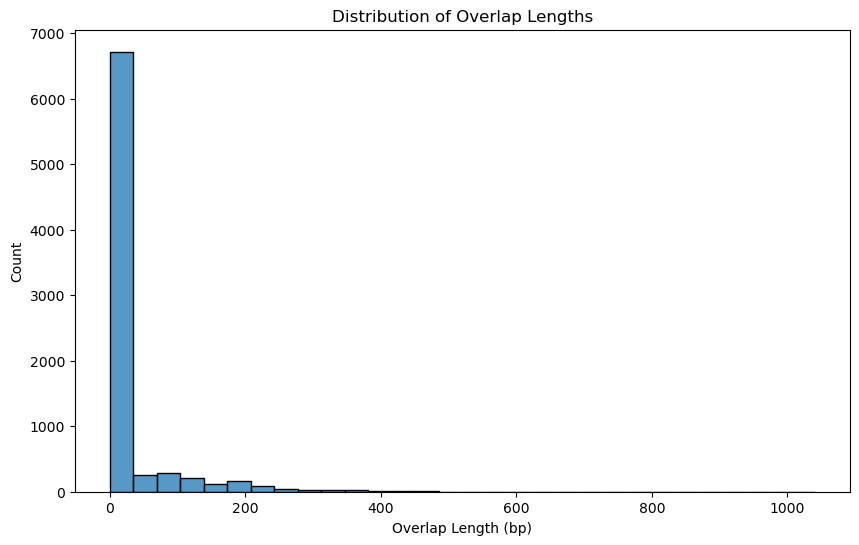

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_overlap_lengths(overlaps_df, ax)


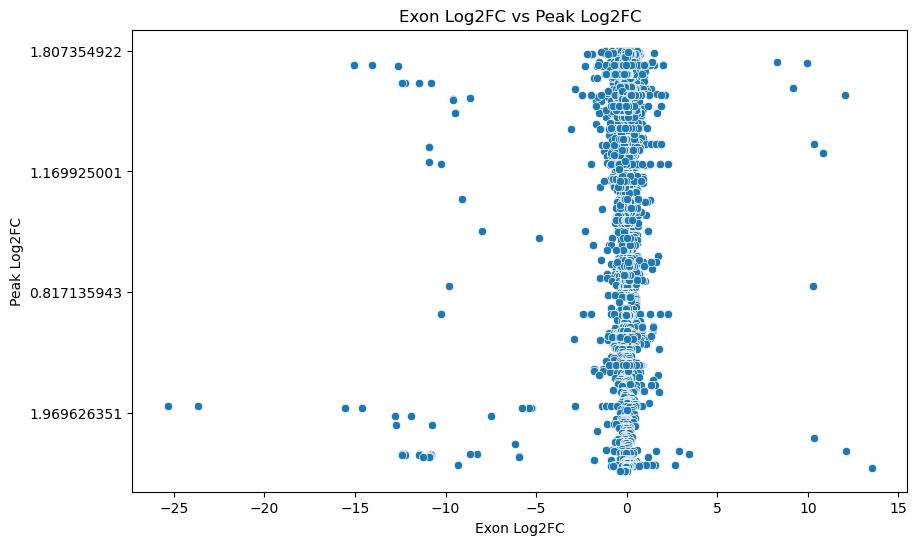

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_fc_correlation(overlaps_df, peaks_df, ax)

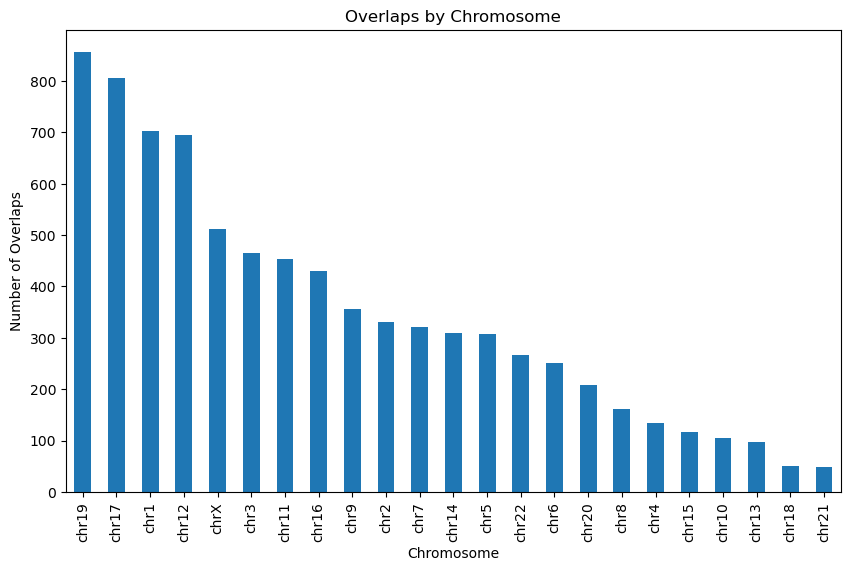

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_chromosome_distribution(overlaps_df, ax)

In [29]:
total_peaks = len(peaks_df)
total_exons = len(dexseq_df)
peaks_with_overlaps = len(overlaps_df['peak_id'].unique())
exons_with_overlaps = len(overlaps_df['exon_id'].unique())

print(f"Total Peaks: {total_peaks}")
print(f"Total Diff. Expressed Exons: {total_exons}")
print(f"Peaks with Overlaps: {peaks_with_overlaps}")
print(f"Exons with Overlaps: {exons_with_overlaps}")
print(f"Total Overlap Events: {len(overlaps_df)}")

Total Peaks: 1136
Total Diff. Expressed Exons: 519126
Peaks with Overlaps: 868
Exons with Overlaps: 173
Total Overlap Events: 7987


In [30]:
overlaps_df.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0


In [31]:
dexseq_df.head()

,dexseq_name,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.15:E001,ENSG00000000003.15,E001,9.064419,0.016163,3928.904378,0.000000e+00,0.000000e+00,5.931265,5.009454,-0.513830,chrX,100627108,100627108,1,-,10,12,6,2,10,8,12,10,14
1,ENSG00000000003.15:E002,ENSG00000000003.15,E002,1364.225638,0.007380,465.843450,6.972364e-102,8.791361e-102,31.857029,31.513293,-0.075000,chrX,100627109,100629986,2878,-,1106,1345,750,970,1266,1057,1521,2781,2375
2,ENSG00000000003.15:E003,ENSG00000000003.15,E003,443.805530,0.009201,1962.650578,0.000000e+00,0.000000e+00,24.503872,24.252599,-0.056804,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.15:E004,ENSG00000000003.15,E004,1.978581,0.020921,3476.876104,0.000000e+00,0.000000e+00,2.634388,2.801898,0.180282,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.15:E005,ENSG00000000003.15,E005,330.134019,0.007735,2830.512068,0.000000e+00,0.000000e+00,22.609421,22.418042,-0.044010,chrX,100632485,100632540,56,-,269,321,184,215,299,267,354,675,613


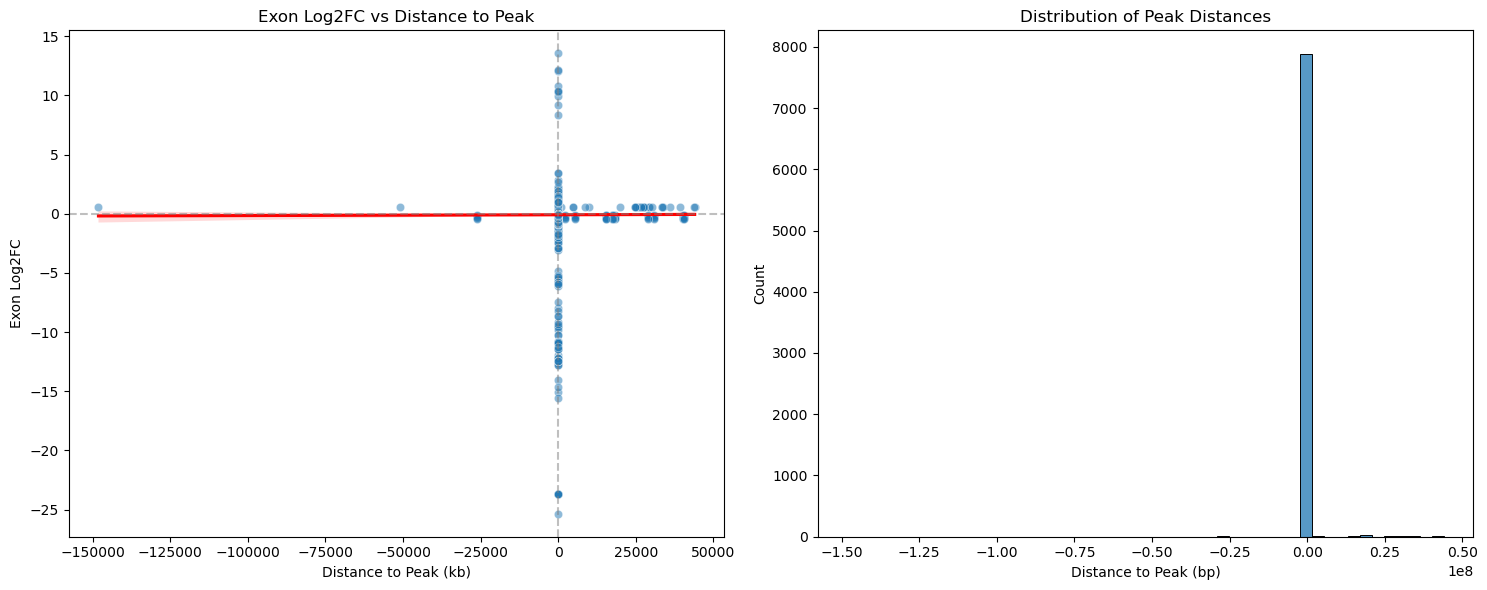

In [32]:
# Create visualization
fig = visualize_distance_analysis(overlaps_df)
plt.show()

# Complementarity analysis

In [33]:
ASE1 = 'AACATTCCTTGGAAAAG'
ASE2 = 'CGTCATTCTCATCGGAA'

cASE1 = 'CTTTTCCAAGGAATGTT'
cASE2 = 'TTCCGATGAGAATGACG'

In [34]:
enriched_overlaps_df3 = analyze_overlaps_with_als(overlaps_df, dexseq_df)

Starting ALS complementarity analysis...
Using 71 CPU cores for parallel processing
Split data into 72 chunks of approximately 112 rows each
Starting parallel processing...
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chunk of size 112
Processing chun

In [38]:
# import os
# os.environ["MKL_NUM_THREADS"] = str(multiprocessing.cpu_count())
# os.environ["NUMEXPR_NUM_THREADS"] = str(multiprocessing.cpu_count())
# os.environ["OMP_NUM_THREADS"] = str(multiprocessing.cpu_count())

# # Run analysis
# enriched_overlaps_df = analyze_overlaps_with_als_optimized_2(overlaps_df, dexseq_df)

In [39]:
# enriched_overlaps_df3 = analyze_overlaps_with_als(overlaps_df, dexseq_df)

In [40]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0,0.0435,E014,6.0,5.0,118.0,E013,8.0,7.0,129.0,E015,6.0,5.0,93.0
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0,0.6340,E001,5.0,5.0,31.0,NaN,NaN,NaN,NaN,E002,7.0,6.0,336.0
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0,0.4505,E002,7.0,6.0,336.0,E001,5.0,5.0,31.0,E003,7.0,7.0,384.0
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0,0.0905,E003,7.0,7.0,384.0,E002,7.0,6.0,336.0,E004,5.0,4.0,124.0
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0,-0.1635,NaN,NaN,NaN,NaN,E003,7.0,7.0,384.0,E005,4.0,5.0,37.0


# Load the data back

In [41]:
output_path = "output_v38/enriched_overlaps_with_als.csv"
pickle_path = "output_v38/enriched_overlaps_with_als.pkl"

In [42]:
# %%script false --no-raise-error
# Save as pickle (better for preserving data types and complex objects)
enriched_overlaps_df3.to_pickle(pickle_path)

# Save as CSV
enriched_overlaps_df3.to_csv(output_path, index=False)

In [43]:
# Load the data back

# From CSV
# loaded_df_csv = pd.read_csv(output_path)

# From pickle
enriched_overlaps_df3 = pd.read_pickle(pickle_path)

In [44]:
enriched_overlaps_df3.shape

(7987, 22)

In [45]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0,0.0435,E014,6.0,5.0,118.0,E013,8.0,7.0,129.0,E015,6.0,5.0,93.0
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0,0.6340,E001,5.0,5.0,31.0,NaN,NaN,NaN,NaN,E002,7.0,6.0,336.0
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0,0.4505,E002,7.0,6.0,336.0,E001,5.0,5.0,31.0,E003,7.0,7.0,384.0
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0,0.0905,E003,7.0,7.0,384.0,E002,7.0,6.0,336.0,E004,5.0,4.0,124.0
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0,-0.1635,NaN,NaN,NaN,NaN,E003,7.0,7.0,384.0,E005,4.0,5.0,37.0


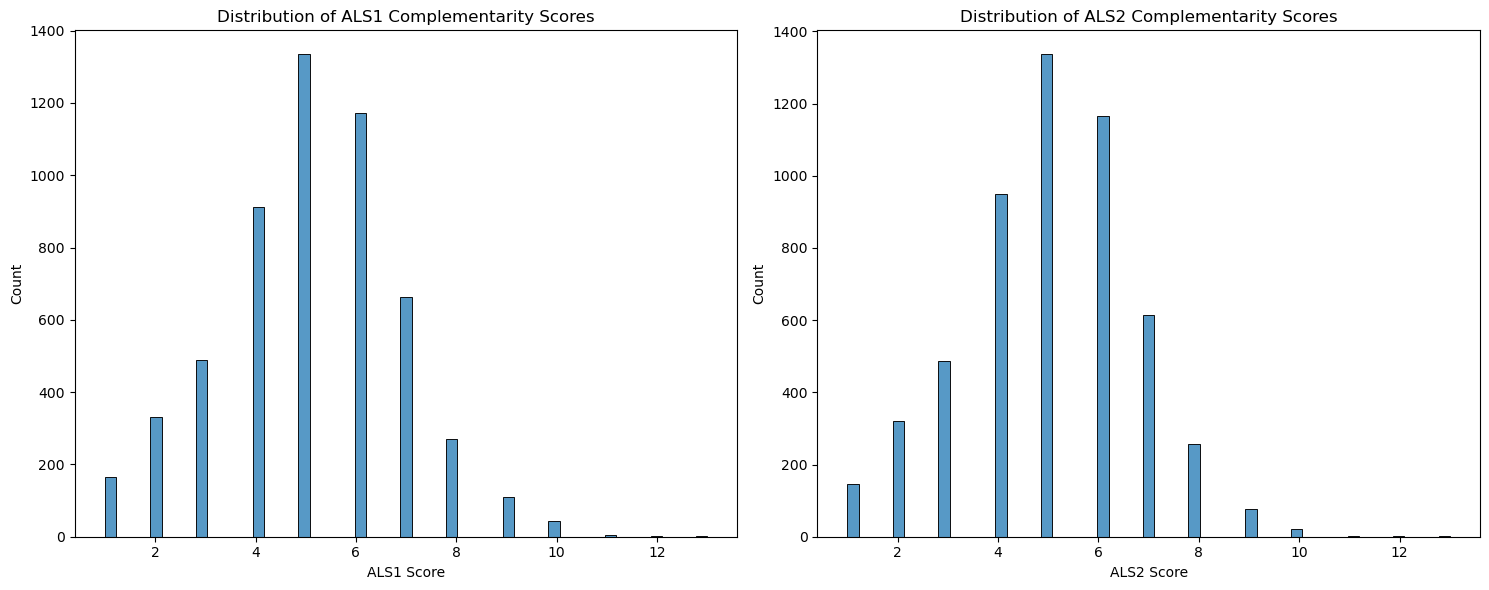

In [46]:
# Visualize ALS scores distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=enriched_overlaps_df3, x='current_exon_als1_score', ax=ax1)
ax1.set_title('Distribution of ALS1 Complementarity Scores')
ax1.set_xlabel('ALS1 Score')

sns.histplot(data=enriched_overlaps_df3, x='next_exon_als1_score', ax=ax2)
ax2.set_title('Distribution of ALS2 Complementarity Scores')
ax2.set_xlabel('ALS2 Score')

plt.tight_layout()
plt.show()

In [47]:
enriched_overlaps_df3["groupID"] = enriched_overlaps_df3["dexseq_name"].str.split(':').str[0]

In [48]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0,0.0435,E014,6.0,5.0,118.0,E013,8.0,7.0,129.0,E015,6.0,5.0,93.0,ENSG00000004897.12
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0,0.6340,E001,5.0,5.0,31.0,NaN,NaN,NaN,NaN,E002,7.0,6.0,336.0,ENSG00000005194.15
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0,0.4505,E002,7.0,6.0,336.0,E001,5.0,5.0,31.0,E003,7.0,7.0,384.0,ENSG00000005194.15
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0,0.0905,E003,7.0,7.0,384.0,E002,7.0,6.0,336.0,E004,5.0,4.0,124.0,ENSG00000005194.15
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0,-0.1635,NaN,NaN,NaN,NaN,E003,7.0,7.0,384.0,E005,4.0,5.0,37.0,ENSG00000005194.15


In [49]:
enriched_overlaps_df3["geneID"] = enriched_overlaps_df3["groupID"].str.split('.').str[0]

In [50]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0,0.0435,E014,6.0,5.0,118.0,E013,8.0,7.0,129.0,E015,6.0,5.0,93.0,ENSG00000004897.12,ENSG00000004897
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0,0.6340,E001,5.0,5.0,31.0,NaN,NaN,NaN,NaN,E002,7.0,6.0,336.0,ENSG00000005194.15,ENSG00000005194
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0,0.4505,E002,7.0,6.0,336.0,E001,5.0,5.0,31.0,E003,7.0,7.0,384.0,ENSG00000005194.15,ENSG00000005194
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0,0.0905,E003,7.0,7.0,384.0,E002,7.0,6.0,336.0,E004,5.0,4.0,124.0,ENSG00000005194.15,ENSG00000005194
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0,-0.1635,NaN,NaN,NaN,NaN,E003,7.0,7.0,384.0,E005,4.0,5.0,37.0,ENSG00000005194.15,ENSG00000005194


In [51]:
import mygene

# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
sel_genes_no_version = enriched_overlaps_df3["geneID"]

# Query the gene symbols
results = mg.querymany(sel_genes_no_version, scopes='ensembl.gene', fields='symbol', species='human')

686 input query terms found dup hits:	[('ENSG00000005194', 10), ('ENSG00000005339', 2), ('ENSG00000005893', 4), ('ENSG00000006652', 5), ('
3 input query terms found no hit:	['ENSG00000269900', 'ENSG00000269900', 'ENSG00000269900']


In [52]:
# Add gene names to enriched_overlaps_df3
enriched_overlaps_df3["gene_name"] = [item.get('symbol', '') for item in results]

In [53]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID,gene_name
0,E014,474,chr17:47132254-47132464,ENSG00000004897.12:E014,chr17,43.5,117.0,-0.104318,0.0,0.0435,E014,6.0,5.0,118.0,E013,8.0,7.0,129.0,E015,6.0,5.0,93.0,ENSG00000004897.12,ENSG00000004897,CDC27
1,E001,40,chr16:57428714-57428958,ENSG00000005194.15:E001,chr16,634.0,0.0,-0.080662,0.0,0.6340,E001,5.0,5.0,31.0,NaN,NaN,NaN,NaN,E002,7.0,6.0,336.0,ENSG00000005194.15,ENSG00000005194,CIAPIN1
2,E002,40,chr16:57428714-57428958,ENSG00000005194.15:E002,chr16,450.5,0.0,-0.268498,0.0,0.4505,E002,7.0,6.0,336.0,E001,5.0,5.0,31.0,E003,7.0,7.0,384.0,ENSG00000005194.15,ENSG00000005194,CIAPIN1
3,E003,40,chr16:57428714-57428958,ENSG00000005194.15:E003,chr16,90.5,223.0,-0.222241,0.0,0.0905,E003,7.0,7.0,384.0,E002,7.0,6.0,336.0,E004,5.0,4.0,124.0,ENSG00000005194.15,ENSG00000005194,CIAPIN1
4,E004,40,chr16:57428714-57428958,ENSG00000005194.15:E004,chr16,-163.5,20.0,-0.263524,0.0,-0.1635,NaN,NaN,NaN,NaN,E003,7.0,7.0,384.0,E005,4.0,5.0,37.0,ENSG00000005194.15,ENSG00000005194,CIAPIN1


In [54]:
enriched_overlaps_df3_backup = enriched_overlaps_df3.copy()

In [55]:
# %%script false --no-raise-error
enriched_overlaps_df3 = enriched_overlaps_df3_backup.copy()

In [56]:
enriched_overlaps_df3.loc[enriched_overlaps_df3["current_exon_als1_score"].isna(), "current_exon_als1_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["current_exon_als2_score"].isna(), "current_exon_als2_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["next_exon_als1_score"].isna(), "next_exon_als1_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["next_exon_als2_score"].isna(), "next_exon_als2_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["previous_exon_als1_score"].isna(), "previous_exon_als1_score"] = 0
enriched_overlaps_df3.loc[enriched_overlaps_df3["previous_exon_als2_score"].isna(), "previous_exon_als2_score"] = 0

In [57]:
enriched_overlaps_df3["sum_als1_score"] = enriched_overlaps_df3["current_exon_als1_score"] + enriched_overlaps_df3["next_exon_als1_score"] + enriched_overlaps_df3["previous_exon_als1_score"]
enriched_overlaps_df3["sum_als2_score"] = enriched_overlaps_df3["current_exon_als2_score"] + enriched_overlaps_df3["next_exon_als2_score"] + enriched_overlaps_df3["previous_exon_als2_score"]


In [58]:
enriched_overlaps_df3 = enriched_overlaps_df3[(enriched_overlaps_df3["sum_als1_score"] > 0) | (enriched_overlaps_df3["sum_als2_score"] > 0)]

In [59]:
enriched_overlaps_df3.shape

(7795, 27)

In [60]:
enriched_overlaps_df3.sort_values(by="sum_als1_score", ascending=False, inplace=True)

In [61]:
enriched_overlaps_df3.shape

(7795, 27)

In [62]:
enriched_overlaps_df3.head()

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID,gene_name,sum_als1_score,sum_als2_score
3973,E006,629,chr10:128105523-128105738,ENSG00000148773.14:E006,chr10,-645.5,215.0,0.040267,3.611517e-03,-0.6455,E006,10.0,7.0,6295.0,E005,7.0,7.0,550.0,E007,10.0,6.0,156.0,ENSG00000148773.14,ENSG00000148773,MKI67,27.0,20.0
2937,E003,575,chrX:108733517-108733852,ENSG00000133124.12:E003,chrX,6133.5,0.0,-0.060474,1.199368e-08,6.1335,E003,9.0,8.0,10055.0,E002,9.0,7.0,2575.0,E004,8.0,9.0,3831.0,ENSG00000133124.12,ENSG00000133124,IRS4,26.0,24.0
2936,E003,680,chrX:108733099-108733294,ENSG00000133124.12:E003,chrX,5645.5,0.0,-0.060474,1.199368e-08,5.6455,E003,9.0,8.0,10055.0,E002,9.0,7.0,2575.0,E004,8.0,9.0,3831.0,ENSG00000133124.12,ENSG00000133124,IRS4,26.0,24.0
4097,E004,896,chr1:112917518-112917838,ENSG00000155380.13:E004,chr1,986.5,0.0,-0.595376,0.000000e+00,0.9865,E004,8.0,8.0,972.0,E003,9.0,8.0,2310.0,E005,9.0,7.0,840.0,ENSG00000155380.13,ENSG00000155380,SLC16A1,26.0,23.0
7822,E009,800,chr19:6413697-6413897,ENSG00000284159.1+ENSG00000088247.18:E009,chr19,107.5,41.0,-0.067994,0.000000e+00,0.1075,E009,6.0,6.0,98.0,E008,13.0,6.0,68.0,E010,6.0,6.0,226.0,ENSG00000284159.1+ENSG00000088247.18,ENSG00000284159,MIR3940,25.0,18.0


In [63]:
enriched_overlaps_df3.shape

(7795, 27)

In [64]:
enriched_overlaps_df3.to_excel('enriched_overlaps_df3_with_sum_scores2.xlsx', index=False)
enriched_overlaps_df3.to_csv('enriched_overlaps_df3_with_sum_scores2.csv', index=False)

# Explore the data

In [65]:
enriched_overlaps_df3 = pd.read_excel('enriched_overlaps_df3_with_sum_scores2.xlsx')

In [66]:
pd.set_option('display.max_columns', None)
print(enriched_overlaps_df3[enriched_overlaps_df3.peak_name == 'chr1:70148486-70148679'].shape)
enriched_overlaps_df3[(enriched_overlaps_df3.peak_name == 'chr1:70148486-70148679') & (abs(enriched_overlaps_df3.exon_log2fc) > 0.3)]

(6, 27)


,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID,gene_name,sum_als1_score,sum_als2_score
562,E063,132,chr1:70148486-70148679,ENSG00000033122.21:E063,chr1,635.5,0,0.354959,0.0,0.6355,E063,11,6,117.0,NaN,0,0,NaN,E064,7,6,198.0,ENSG00000033122.21,ENSG00000033122,LRRC7,18,12
5782,E062,132,chr1:70148486-70148679,ENSG00000033122.21:E062,chr1,1386.5,0,0.359327,0.0,1.3865,NaN,0,0,NaN,E061,6,6,75.0,NaN,0,0,NaN,ENSG00000033122.21,ENSG00000033122,LRRC7,6,6
6883,E061,132,chr1:70148486-70148679,ENSG00000033122.21:E061,chr1,1424.5,0,0.349547,0.0,1.4245,NaN,0,0,NaN,E060,5,4,43.0,NaN,0,0,NaN,ENSG00000033122.21,ENSG00000033122,LRRC7,5,4


In [82]:
enriched_overlaps_df3[(enriched_overlaps_df3.gene_name == 'LRRC7') & (abs(enriched_overlaps_df3.exon_log2fc) > 0.3)]

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID,gene_name,sum_als1_score,sum_als2_score
562,E063,132,chr1:70148486-70148679,ENSG00000033122.21:E063,chr1,635.5,0,0.354959,0.0,0.6355,E063,11,6,117.0,NaN,0,0,NaN,E064,7,6,198.0,ENSG00000033122.21,ENSG00000033122,LRRC7,18,12
5782,E062,132,chr1:70148486-70148679,ENSG00000033122.21:E062,chr1,1386.5,0,0.359327,0.0,1.3865,NaN,0,0,NaN,E061,6,6,75.0,NaN,0,0,NaN,ENSG00000033122.21,ENSG00000033122,LRRC7,6,6
6883,E061,132,chr1:70148486-70148679,ENSG00000033122.21:E061,chr1,1424.5,0,0.349547,0.0,1.4245,NaN,0,0,NaN,E060,5,4,43.0,NaN,0,0,NaN,ENSG00000033122.21,ENSG00000033122,LRRC7,5,4


In [83]:

enriched_overlaps_df3[(enriched_overlaps_df3.gene_name == 'COMMD2')]

,exon_id,peak_id,peak_name,dexseq_name,chromosome,distance_to_peak,overlap_length,exon_log2fc,exon_padj,distance_kb,current_exon_id,current_exon_als1_score,current_exon_als2_score,current_exon_sequence_length,previous_exon_id,previous_exon_als1_score,previous_exon_als2_score,previous_exon_sequence_length,next_exon_id,next_exon_als1_score,next_exon_als2_score,next_exon_sequence_length,groupID,geneID,gene_name,sum_als1_score,sum_als2_score
179,E002,622,chr3:149739286-149739508,ENSG00000114744.9:E002,chr3,-2010.5,0,0.111998,0.000000e+00,-2.0105,NaN,0,0,NaN,E001,13,7,2918.0,E003,7,5,149.0,ENSG00000114744.9,ENSG00000114744,COMMD2,20,12
336,E001,622,chr3:149739286-149739508,ENSG00000114744.9:E001,chr3,-533.5,222,-0.114446,2.520223e-18,-0.5335,E001,13,7,2918.0,NaN,0,0,NaN,E002,6,4,36.0,ENSG00000114744.9,ENSG00000114744,COMMD2,19,11
6625,E003,622,chr3:149739286-149739508,ENSG00000114744.9:E003,chr3,-2103.0,0,0.131712,0.000000e+00,-2.1030,NaN,0,0,NaN,NaN,0,0,NaN,E004,5,5,144.0,ENSG00000114744.9,ENSG00000114744,COMMD2,5,5


In [84]:
def examine_commd2_exon(db, gene_id="ENSG00000114744.9"):
    """
    Examine the COMMD2 gene's E001 exon details
    """
    # Get all exonic parts for COMMD2
    exons = []
    for feature in db.features_of_type('exonic_part', order_by='start'):
        if gene_id in feature.attributes.get('gene_id', []):
            exons.append(feature)
    
    # Sort exons by position
    exons.sort(key=lambda x: x.start)
    
    # Find E001 and its position in the gene
    for i, exon in enumerate(exons):
        if 'E001' in exon.id or '001' in exon.attributes.get('exonic_part_number', []):
            print(f"\nExon E001 details:")
            print(f"Position: {i+1} out of {len(exons)} exons")
            print(f"Coordinates: {exon.seqid}:{exon.start}-{exon.end}")
            print(f"Length: {exon.end - exon.start} bp")
            print(f"Transcripts: {exon.attributes.get('transcripts', ['None'])}")
            print("\nSurrounding exons:")
            if i > 0:
                prev_exon = exons[i-1]
                print(f"Previous exon: {prev_exon.id}")
                print(f"Previous coordinates: {prev_exon.seqid}:{prev_exon.start}-{prev_exon.end}")
            if i < len(exons)-1:
                next_exon = exons[i+1]
                print(f"Next exon: {next_exon.id}")
                print(f"Next coordinates: {next_exon.seqid}:{next_exon.start}-{next_exon.end}")
            break

# Run the analysis
examine_commd2_exon(db)


Exon E001 details:
Position: 1 out of 20 exons
Coordinates: chr3:149738472-149741389
Length: 2917 bp
Transcripts: ['ENST00000473414.6']

Surrounding exons:
Next exon: exonic_part_468761
Next coordinates: chr3:149741390-149741425


In [89]:
def print_all_commd2_exons(db, gene_id="ENSG00000114744.9"):
    """
    Print details of all exons in the COMMD2 gene
    """
    # Get all exonic parts for COMMD2
    exons = []
    for feature in db.features_of_type('exonic_part', order_by='start'):
        if gene_id in feature.attributes.get('gene_id', []):
            exons.append(feature)
    
    # Sort exons by position
    exons.sort(key=lambda x: x.start)
    
    print(f"\nCOMM2 Gene Exon Details:")
    print(f"Total number of exons: {len(exons)}")
    print("\nExon coordinates:")
    print(f"{'Exon ID':<10} {'Coordinates':<30} {'Length':<10} {'Transcripts'}")
    print("-" * 80)
    
    for exon in exons:
        exon_number = exon.attributes.get('exonic_part_number', ['???'])[0]
        coordinates = f"{exon.seqid}:{exon.start}-{exon.end}"
        length = exon.end - exon.start
        transcripts = ','.join(exon.attributes.get('transcripts', ['None']))
        
        print(f"E{exon_number:<9} {coordinates:<30} {length:<10} {transcripts}")

# Run the analysis
print_all_commd2_exons(db)


COMM2 Gene Exon Details:
Total number of exons: 20

Exon coordinates:
Exon ID    Coordinates                    Length     Transcripts
--------------------------------------------------------------------------------
E001       chr3:149738472-149741389       2917       ENST00000473414.6
E002       chr3:149741390-149741425       35         ENST00000473414.6+ENST00000491617.5
E003       chr3:149741426-149741574       148        ENST00000463077.5+ENST00000473414.6+ENST00000491617.5
E004       chr3:149741575-149741718       143        ENST00000463077.5+ENST00000473414.6+ENST00000491617.5+ENST00000483708.1
E005       chr3:149750257-149750382       125        ENST00000491617.5
E006       chr3:149750503-149750677       174        ENST00000469896.1
E007       chr3:149750678-149750786       108        ENST00000473414.6+ENST00000483708.1+ENST00000469896.1+ENST00000463077.5+ENST00000491617.5
E008       chr3:149750787-149750851       64         ENST00000473414.6+ENST00000483708.1+ENST00000469896.1

In [101]:
import requests
import json

def get_ensembl_exon_info(gene_id="ENSG00000114744", assembly="GRCh38"):
    """
    Get canonical exon information from Ensembl
    """
    server = "https://rest.ensembl.org"
    ext = f"/lookup/id/{gene_id}?expand=1"
    
    r = requests.get(server + ext, headers={"Content-Type": "application/json"})
    
    if r.ok:
        decoded = r.json()
        print("\nEnsembl Canonical Transcript Information:")
        print(f"Gene: {decoded.get('display_name')} ({gene_id})")
        print(f"Canonical transcript: {decoded.get('canonical_transcript')}")
        
        # Get transcript details
        transcripts = decoded.get('Transcript', [])
        print(f"\nFound {len(transcripts)} transcripts")
        
        # Find canonical transcript
        canonical = next((t for t in transcripts if t['is_canonical']), None)
        if canonical:
            print("\nCanonical transcript exon structure:")
            print(f"{'Exon Number':<12} {'Coordinates':<30} {'Length':<10} {'Phase'}")
            print("-" * 80)
            
            sorted_exons = sorted(canonical['Exon'], key=lambda x: x['start'])
            for i, exon in enumerate(sorted_exons, 1):
                coords = f"chr{decoded['seq_region_name']}:{exon['start']}-{exon['end']}"
                length = exon['end'] - exon['start'] + 1
                print(f"{i:<12} {coords:<30} {length:<10} {exon.get('phase', 'NA')}")
                
            # Compare with DexSeq parts
            print("\nComparison with DexSeq parts:")
            dexseq_parts = [(149738472, 149741389),
                            (149741390, 149741425),
                            (149741426, 149741574),
                            (149741575, 149741718),
                            (149750257, 149750382),
                            (149750503, 149750677),
                            (149750678, 149750786),
                            (149750787, 149750851),
                            (149751323, 149751402),
                            (149751403, 149751485),
                            (149751486, 149751810),
                            (149751811, 149752058),
                            (149752059, 149752209),
                            (149752210, 149752287),
                            (149752288, 149752377),
                            (149752378, 149752398),
                            (149752399, 149752450),
                            (149752451, 149752472),
                            (149752473, 149752489),
                            (149752490, 149752495)]
            
            sorted_exons = sorted(canonical['Exon'], key=lambda x: x['start'])
            for i, exon in enumerate(sorted_exons, 1):
                overlapping_parts = []
                for j, (start, end) in enumerate(dexseq_parts, 1):
                    if (start <= exon['end'] and end >= exon['start']):
                        overlapping_parts.append(f"E{j:03d}")
                if overlapping_parts:
                    print(f"Canonical Exon {i} overlaps with DexSeq parts: {', '.join(overlapping_parts)}")
    else:
        print(f"Failed to fetch data: {r.status_code}")

# Run the analysis
get_ensembl_exon_info()


Ensembl Canonical Transcript Information:
Gene: COMMD2 (ENSG00000114744)
Canonical transcript: ENST00000473414.6

Found 7 transcripts

Canonical transcript exon structure:
Exon Number  Coordinates                    Length     Phase
--------------------------------------------------------------------------------
1            chr3:149738472-149741718       3247       NA
2            chr3:149750678-149750851       174        NA
3            chr3:149751403-149751485       83         NA
4            chr3:149752210-149752287       78         NA
5            chr3:149752378-149752489       112        NA

Comparison with DexSeq parts:
Canonical Exon 1 overlaps with DexSeq parts: E001, E002, E003, E004
Canonical Exon 2 overlaps with DexSeq parts: E007, E008
Canonical Exon 3 overlaps with DexSeq parts: E010
Canonical Exon 4 overlaps with DexSeq parts: E014
Canonical Exon 5 overlaps with DexSeq parts: E016, E017, E018, E019


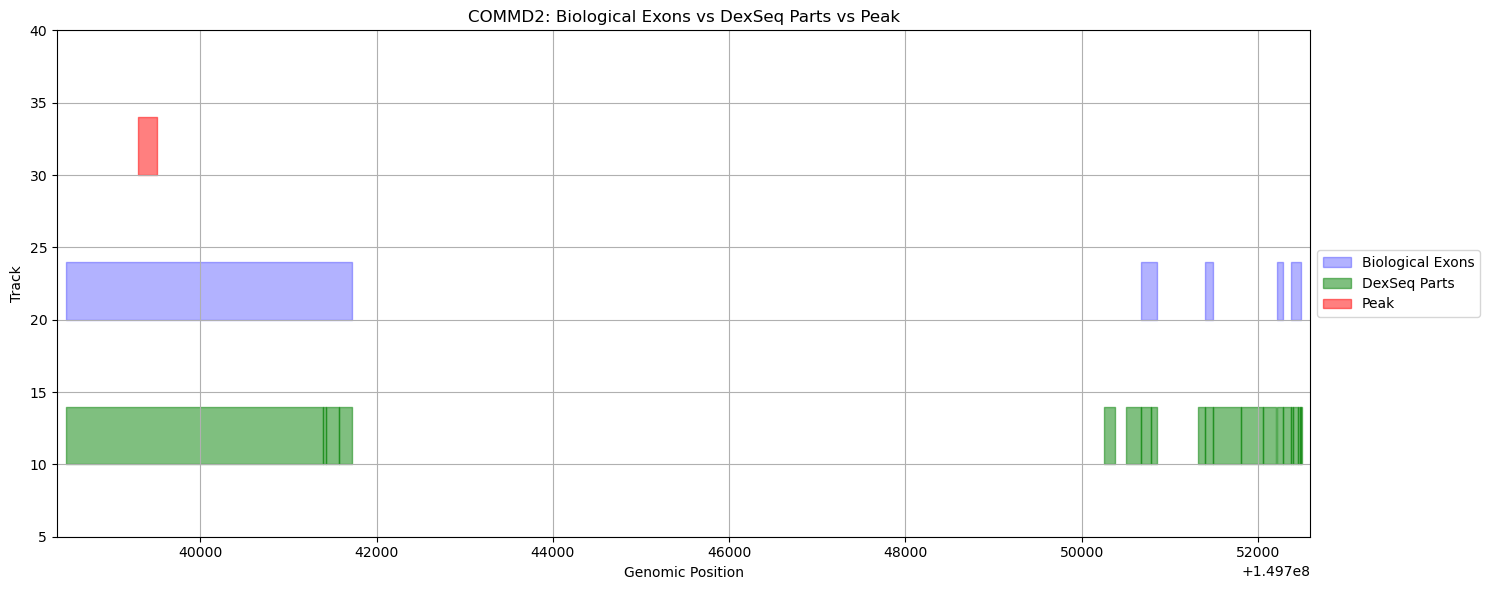

Peak overlaps with Biological Exon 1: 149,739,286 - 149,739,508 (222 bp)


In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Define biological exons (from 5' to 3')
biological_exons = [
    (149738472, 149741718, "Biological Exon 1"),  # 3247 bp
    (149750678, 149750851, "Biological Exon 2"),  # 174 bp
    (149751403, 149751485, "Biological Exon 3"),  # 83 bp
    (149752210, 149752287, "Biological Exon 4"),  # 78 bp
    (149752378, 149752489, "Biological Exon 5")   # 112 bp
]

# Define DexSeq parts
dexseq_parts = [
    (149738472, 149741389, "E001"),
    (149741390, 149741425, "E002"),
    (149741426, 149741574, "E003"),
    (149741575, 149741718, "E004"),
    (149750257, 149750382, "E005"),
    (149750503, 149750677, "E006"),
    (149750678, 149750786, "E007"),
    (149750787, 149750851, "E008"),
    (149751323, 149751402, "E009"),
    (149751403, 149751485, "E010"),
    (149751486, 149751810, "E011"),
    (149751811, 149752058, "E012"),
    (149752059, 149752209, "E013"),
    (149752210, 149752287, "E014"),
    (149752288, 149752377, "E015"),
    (149752378, 149752398, "E016"),
    (149752399, 149752450, "E017"),
    (149752451, 149752472, "E018"),
    (149752473, 149752489, "E019"),
    (149752490, 149752495, "E020")
]

# Peak coordinates
peak = (149739286, 149739508, "Peak")

fig, ax = plt.subplots(figsize=(15, 6))

# Plot biological exons
for start, end, label in biological_exons:
    ax.broken_barh([(start, end-start)], (20, 4), 
                   color='blue', alpha=0.3, label=label)

# Plot DexSeq parts
for start, end, label in dexseq_parts:
    ax.broken_barh([(start, end-start)], (10, 4), 
                   color='green', alpha=0.5, label=label)

# Plot peak
ax.broken_barh([(peak[0], peak[1]-peak[0])], (30, 4), 
               color='red', alpha=0.5, label=peak[2])

# Customize plot
ax.set_ylim(5, 40)
ax.set_xlim(min(min(x[0] for x in biological_exons), min(x[0] for x in dexseq_parts))-100,
            max(max(x[1] for x in biological_exons), max(x[1] for x in dexseq_parts))+100)
ax.set_xlabel('Genomic Position')
ax.set_ylabel('Track')
ax.grid(True)

# Create custom legend with one entry per type
handles, labels = ax.get_legend_handles_labels()
biological_legend = plt.Rectangle((0,0),1,1, color='blue', alpha=0.3)
dexseq_legend = plt.Rectangle((0,0),1,1, color='green', alpha=0.5)
peak_legend = plt.Rectangle((0,0),1,1, color='red', alpha=0.5)

ax.legend([biological_legend, dexseq_legend, peak_legend],
         ['Biological Exons', 'DexSeq Parts', 'Peak'],
         loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('COMMD2: Biological Exons vs DexSeq Parts vs Peak')
plt.tight_layout()
plt.show()

# Calculate intersection with peak
for i, (start, end, label) in enumerate(biological_exons, 1):
    if peak[0] <= end and peak[1] >= start:
        intersection_start = max(start, peak[0])
        intersection_end = min(end, peak[1])
        print(f"Peak overlaps with {label}: {intersection_start:,} - {intersection_end:,} ({intersection_end-intersection_start:,} bp)")

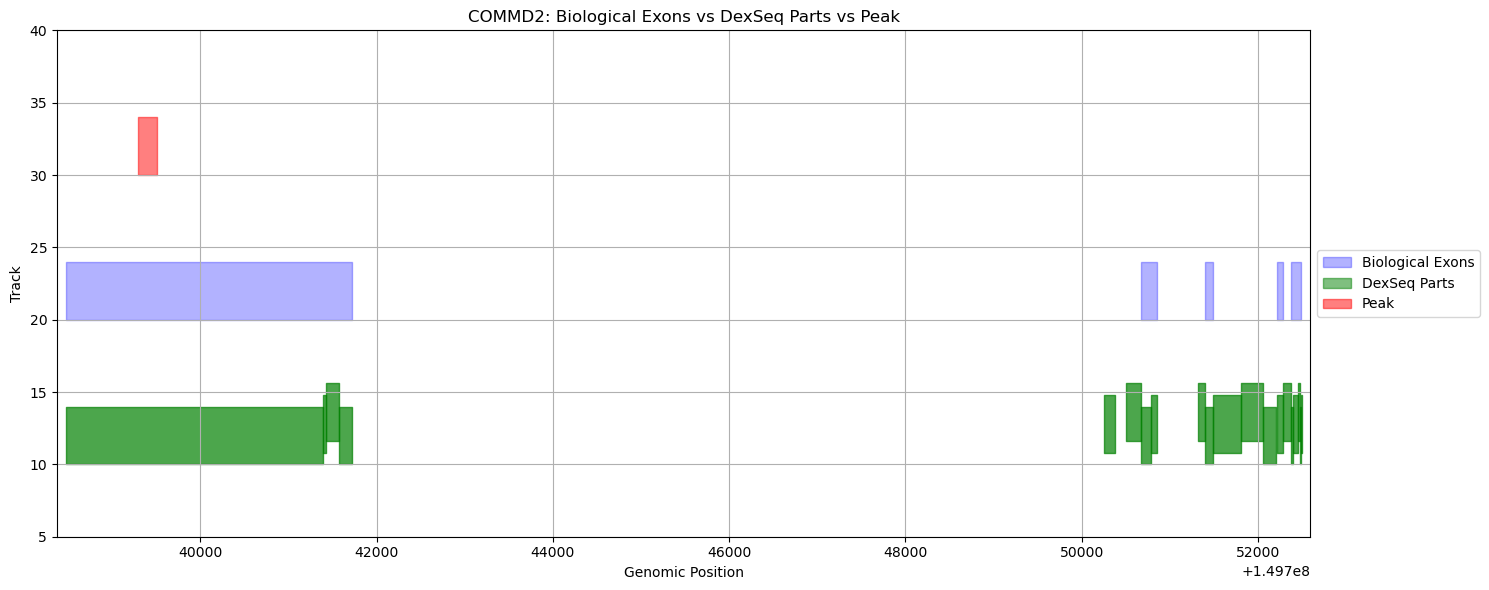

Peak overlaps with Biological Exon 1: 149,739,286 - 149,739,508 (222 bp)


In [104]:
import matplotlib.pyplot as plt
import numpy as np

# Define biological exons (from 5' to 3')
biological_exons = [
    (149738472, 149741718, "Biological Exon 1"),  # 3247 bp
    (149750678, 149750851, "Biological Exon 2"),  # 174 bp
    (149751403, 149751485, "Biological Exon 3"),  # 83 bp
    (149752210, 149752287, "Biological Exon 4"),  # 78 bp
    (149752378, 149752489, "Biological Exon 5")   # 112 bp
]

# Define DexSeq parts
dexseq_parts = [
    (149738472, 149741389, "E001"),
    (149741390, 149741425, "E002"),
    (149741426, 149741574, "E003"),
    (149741575, 149741718, "E004"),
    (149750257, 149750382, "E005"),
    (149750503, 149750677, "E006"),
    (149750678, 149750786, "E007"),
    (149750787, 149750851, "E008"),
    (149751323, 149751402, "E009"),
    (149751403, 149751485, "E010"),
    (149751486, 149751810, "E011"),
    (149751811, 149752058, "E012"),
    (149752059, 149752209, "E013"),
    (149752210, 149752287, "E014"),
    (149752288, 149752377, "E015"),
    (149752378, 149752398, "E016"),
    (149752399, 149752450, "E017"),
    (149752451, 149752472, "E018"),
    (149752473, 149752489, "E019"),
    (149752490, 149752495, "E020")
]

# Peak coordinates
peak = (149739286, 149739508, "Peak")

fig, ax = plt.subplots(figsize=(15, 6))

# Plot biological exons
for start, end, label in biological_exons:
    ax.broken_barh([(start, end-start)], (20, 4), 
                   color='blue', alpha=0.3, label=label)

# Plot DexSeq parts - with small vertical offset for overlapping parts
for i, (start, end, label) in enumerate(dexseq_parts):
    # Calculate small vertical offset for overlapping regions
    offset = 0.8 * (i % 3)  # This will create up to 3 stacked levels
    ax.broken_barh([(start, end-start)], (10 + offset, 4), 
                   color='green', alpha=0.7, label=label)

# Plot peak
ax.broken_barh([(peak[0], peak[1]-peak[0])], (30, 4), 
               color='red', alpha=0.5, label=peak[2])

# Customize plot
ax.set_ylim(5, 40)
ax.set_xlim(min(min(x[0] for x in biological_exons), min(x[0] for x in dexseq_parts))-100,
            max(max(x[1] for x in biological_exons), max(x[1] for x in dexseq_parts))+100)
ax.set_xlabel('Genomic Position')
ax.set_ylabel('Track')
ax.grid(True)

# Create custom legend with one entry per type
handles, labels = ax.get_legend_handles_labels()
biological_legend = plt.Rectangle((0,0),1,1, color='blue', alpha=0.3)
dexseq_legend = plt.Rectangle((0,0),1,1, color='green', alpha=0.5)
peak_legend = plt.Rectangle((0,0),1,1, color='red', alpha=0.5)

ax.legend([biological_legend, dexseq_legend, peak_legend],
         ['Biological Exons', 'DexSeq Parts', 'Peak'],
         loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('COMMD2: Biological Exons vs DexSeq Parts vs Peak')
plt.tight_layout()
plt.show()

# Calculate intersection with peak
for i, (start, end, label) in enumerate(biological_exons, 1):
    if peak[0] <= end and peak[1] >= start:
        intersection_start = max(start, peak[0])
        intersection_end = min(end, peak[1])
        print(f"Peak overlaps with {label}: {intersection_start:,} - {intersection_end:,} ({intersection_end-intersection_start:,} bp)")

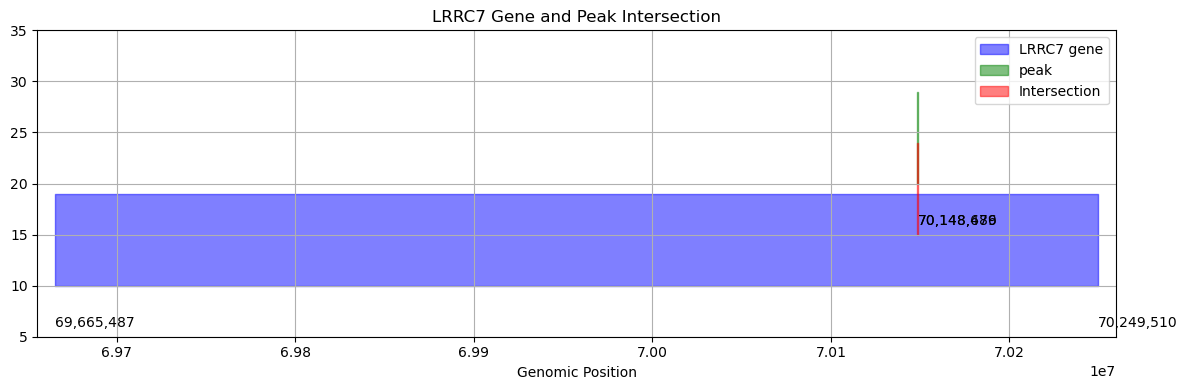

Intersection range: 70,148,486 - 70,148,679 (193 positions)


In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Define ranges
range1 = (69665487, 70249510) # LRRC7 gene coordinates
range2 = (70148486, 70148679) # peak coordinates

fig, ax = plt.subplots(figsize=(12, 4))

# Plot ranges as horizontal bars
ax.broken_barh([(range1[0], range1[1]-range1[0])], (10, 9), color='blue', alpha=0.5, label='LRRC7 gene')
ax.broken_barh([(range2[0], range2[1]-range2[0])], (20, 9), color='green', alpha=0.5, label='peak')

# Calculate and plot intersection
intersection_start = max(range1[0], range2[0])
intersection_end = min(range1[1], range2[1])
ax.broken_barh([(intersection_start, intersection_end-intersection_start)], (15, 9), 
               color='red', alpha=0.5, label='Intersection')

# Customize plot
ax.set_ylim(5, 35)
ax.set_xlim(range1[0]-10000, range1[1]+10000)
ax.set_xlabel('Genomic Position')
ax.grid(True)
ax.legend()

# Add range labels
for i, (start, end) in enumerate([(range1[0], range1[1]), (range2[0], range2[1])]):
    y = 10 if i == 0 else 20
    plt.text(start, y-3, f'{start:,}', verticalalignment='top')
    plt.text(end, y-3, f'{end:,}', verticalalignment='top')

plt.title('LRRC7 Gene and Peak Intersection')
plt.tight_layout()
plt.show()

# Calculate intersection size
intersection_size = intersection_end - intersection_start
print(f"Intersection range: {intersection_start:,} - {intersection_end:,} ({intersection_size:,} positions)")

In [68]:
import requests
import json

def get_transcript_info(gene_id):
    """
    Fetch and display information about all transcripts for a gene
    """
    base_url = "https://rest.ensembl.org"
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }
    
    ext = f"/lookup/id/{gene_id}?expand=1"
    response = requests.get(base_url + ext, headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"Failed to fetch gene data: {response.status_code}")
    
    data = response.json()
    transcripts = data.get('Transcript', [])
    
    print(f"Gene: {gene_id}")
    print(f"Number of transcripts: {len(transcripts)}")
    print("\nTranscript details:")
    
    for transcript in transcripts:
        exon_count = len(transcript.get('Exon', []))
        print(f"\nTranscript ID: {transcript['id']}")
        print(f"Exon count: {exon_count}")
        if exon_count > 0:
            first_exon = transcript['Exon'][0]
            last_exon = transcript['Exon'][-1]
            print(f"First exon coordinates: {first_exon['start']}-{first_exon['end']}")
            print(f"Last exon coordinates: {last_exon['start']}-{last_exon['end']}")

# Get information about all transcripts
get_transcript_info("ENSG00000033122")

Gene: ENSG00000033122
Number of transcripts: 14

Transcript details:

Transcript ID: ENST00000651989
Exon count: 27
First exon coordinates: 69567922-69568641
Last exon coordinates: 70121780-70144364

Transcript ID: ENST00000310961
Exon count: 27
First exon coordinates: 69568398-69568641
Last exon coordinates: 70121780-70123488

Transcript ID: ENST00000370958
Exon count: 8
First exon coordinates: 69568450-69568641
Last exon coordinates: 69873467-69875004

Transcript ID: ENST00000651217
Exon count: 25
First exon coordinates: 69760175-69760393
Last exon coordinates: 70121780-70122243

Transcript ID: ENST00000415775
Exon count: 21
First exon coordinates: 69760187-69760393
Last exon coordinates: 70121780-70121994

Transcript ID: ENST00000588515
Exon count: 6
First exon coordinates: 70107750-70107826
Last exon coordinates: 70147889-70148005

Transcript ID: ENST00000609498
Exon count: 5
First exon coordinates: 70121778-70121870
Last exon coordinates: 70142197-70142253

Transcript ID: ENST0000

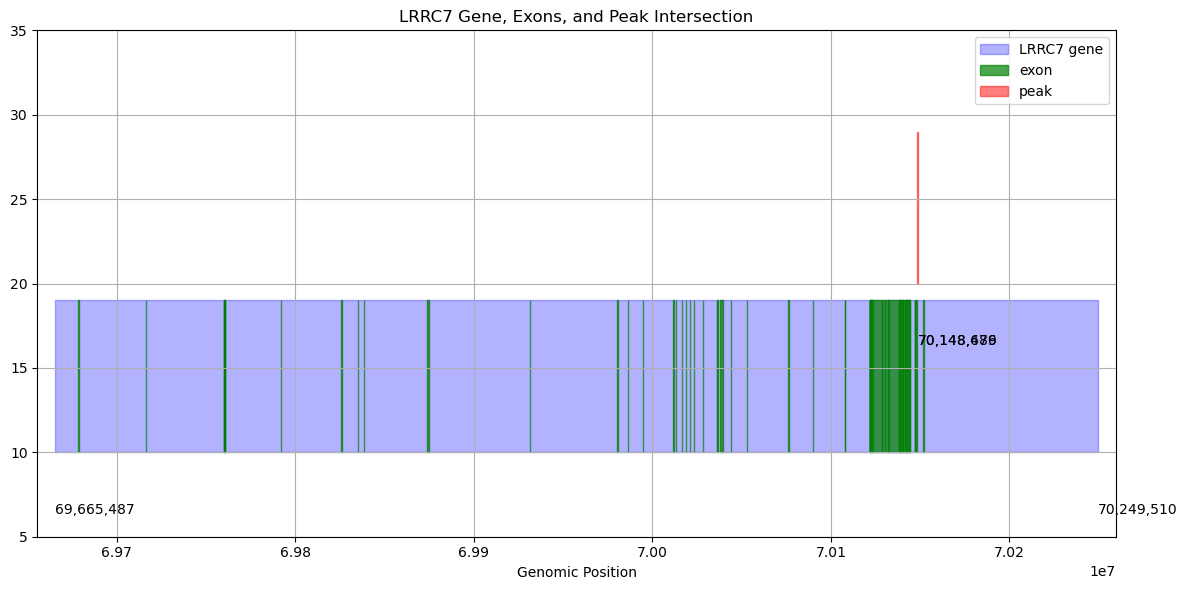

Intersection range: 70,148,486 - 70,148,679 (193 positions)
Number of exons: 57


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import json

def fetch_exon_coordinates(gene_id):
    """Fetch exon coordinates from Ensembl REST API"""
    base_url = "https://rest.ensembl.org"
    headers = {
        "Content-Type": "application/json",
        "Accept": "application/json"
    }
    
    ext = f"/lookup/id/{gene_id}?expand=1"
    response = requests.get(base_url + ext, headers=headers)
    
    if response.status_code != 200:
        return []
    
    data = response.json()
    exon_coords = []
    
    # Collect unique exon coordinates from all transcripts
    for transcript in data.get('Transcript', []):
        for exon in transcript.get('Exon', []):
            coords = (exon['start'], exon['end'])
            if coords not in exon_coords:
                exon_coords.append(coords)
    
    return sorted(exon_coords)

# Define ranges
range1 = (69665487, 70249510)  # LRRC7 gene coordinates
range2 = (70148486, 70148679)  # peak coordinates

# Fetch exon coordinates
exon_coords = fetch_exon_coordinates("ENSG00000033122")

fig, ax = plt.subplots(figsize=(12, 6))

# Plot gene range
ax.broken_barh([(range1[0], range1[1]-range1[0])], (10, 9), 
               color='blue', alpha=0.3, label='LRRC7 gene')

# Plot exons
first_exon = True
for start, end in exon_coords:
    ax.broken_barh([(start, end-start)], (10, 9), 
                  color='green', alpha=0.7, 
                  label='exon' if first_exon else None)
    first_exon = False

# Plot peak
ax.broken_barh([(range2[0], range2[1]-range2[0])], (20, 9), 
               color='red', alpha=0.5, label='peak')

# Customize plot
ax.set_ylim(5, 35)
ax.set_xlim(range1[0]-10000, range1[1]+10000)
ax.set_xlabel('Genomic Position')
ax.grid(True)
ax.legend()

# Add range labels
for i, (start, end) in enumerate([(range1[0], range1[1]), (range2[0], range2[1])]):
    y = 10 if i == 0 else 20
    plt.text(start, y-3, f'{start:,}', verticalalignment='top')
    plt.text(end, y-3, f'{end:,}', verticalalignment='top')

plt.title('LRRC7 Gene, Exons, and Peak Intersection')
plt.tight_layout()
plt.show()

# Calculate intersection size
intersection_size = intersection_end - intersection_start
print(f"Intersection range: {intersection_start:,} - {intersection_end:,} ({intersection_size:,} positions)")
print(f"Number of exons: {len(exon_coords)}")

In [70]:
import gffutils

gff_file = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords/DATA/v38/gencode.v38.annotation.dexseq.gff"
gene_id = "ENSG00000033122.21"

In [71]:
db = gffutils.create_db(gff_file, ":memory:", merge_strategy="create_unique")

In [72]:
def examine_gff_content(gff_file, gene_id, db):
    """
    Examine the content of the GFF file for a specific gene
    """    
    # First, let's look at all features in the database
    print("\nSample of features in the database:")
    for feature in db.all_features():
        print(f"\nFeature type: {feature.featuretype}")
        print(f"ID: {feature.id}")
        print(f"Coordinates: {feature.seqid}:{feature.start}-{feature.end}")
        print("Attributes:", dict(feature.attributes))
        break  # Just show the first one as an example
    
    # Try to find our specific exon
    print("\nTrying to find specific features...")
    try:
        # Try exact ID
        feature = db[f"{gene_id}:E063"]
        print("Found by exact ID!")
    except:
        print("Not found by exact ID")
    
    # Look at all features in the relevant chromosome region
    print("\nFeatures in the relevant region:")
    for feature in db.region(seqid='chr1', start=70147000, end=70149000):
        print(f"\nFeature type: {feature.featuretype}")
        print(f"ID: {feature.id}")
        print(f"Coordinates: {feature.seqid}:{feature.start}-{feature.end}")
        print("Attributes:", dict(feature.attributes))

examine_gff_content(gff_file, gene_id, db)


Sample of features in the database:

Feature type: aggregate_gene
ID: aggregate_gene_1
Coordinates: chr1:11869-14409
Attributes: {'gene_id': ['ENSG00000223972.5']}

Trying to find specific features...
Not found by exact ID

Features in the relevant region:

Feature type: aggregate_gene
ID: aggregate_gene_1845
Coordinates: chr1:69567922-70151945
Attributes: {'gene_id': ['ENSG00000033122.21']}

Feature type: aggregate_gene
ID: aggregate_gene_1851
Coordinates: chr1:70144805-70205579
Attributes: {'gene_id': ['ENSG00000066557.6']}

Feature type: exonic_part
ID: exonic_part_24231
Coordinates: chr1:70147027-70147077
Attributes: {'gene_id': ['ENSG00000033122.21'], 'transcripts': ['ENST00000608744.5+ENST00000609072.5+ENST00000607936.5'], 'exonic_part_number': ['059']}

Feature type: exonic_part
ID: exonic_part_24232
Coordinates: chr1:70147078-70147120
Attributes: {'gene_id': ['ENSG00000033122.21'], 'transcripts': ['ENST00000608744.5+ENST00000609072.5'], 'exonic_part_number': ['060']}

Feature 

- Feature type: exonic_part
- ID: exonic_part_24235
- Coordinates: chr1:70147889-70148005
- Attributes: {'gene_id': ['ENSG00000033122.21'], 'transcripts': ['ENST00000441830.1+ENST00000607936.5+ENST00000588515.5'], 'exonic_part_number': ['063']}

In [73]:
def peek_gff_file(gff_file, num_lines=10):
    """
    Show the first few lines of the GFF file
    """
    with open(gff_file, 'r') as f:
        lines = []
        for line in f:
            if not line.startswith('#'):  # Skip comment lines
                lines.append(line.strip())
                if len(lines) >= num_lines:
                    break
    
    print("Sample lines from GFF file:")
    for line in lines:
        print(line)

# Look at the GFF file content
peek_gff_file(gff_file)

Sample lines from GFF file:
chr1	dexseq_prepare_annotation.py	aggregate_gene	11869	14409	.	+	.	gene_id "ENSG00000223972.5"
chr1	dexseq_prepare_annotation.py	exonic_part	11869	12009	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2"; exonic_part_number "001"
chr1	dexseq_prepare_annotation.py	exonic_part	12010	12057	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "002"
chr1	dexseq_prepare_annotation.py	exonic_part	12058	12178	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2"; exonic_part_number "003"
chr1	dexseq_prepare_annotation.py	exonic_part	12179	12227	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "004"
chr1	dexseq_prepare_annotation.py	exonic_part	12613	12697	.	+	.	gene_id "ENSG00000223972.5"; transcripts "ENST00000456328.2+ENST00000450305.2"; exonic_part_number "005"
chr1	dexseq_prepare_annotation.py	exonic_part	12698	12721	.	+	.	gene

In [74]:
def get_sequence_for_coordinates(chromosome, start, end):
    """Get sequence from Ensembl REST API for given coordinates"""
    server = "https://rest.ensembl.org"
    ext = f"/sequence/region/human/{chromosome}:{start}:{end}:1"
    
    r = requests.get(server + ext, headers={"Content-Type": "application/json"})
    
    if r.status_code != 200:
        return None
        
    return r.json()['seq']

# Get sequence for E063
chromosome = "chr1"
start = 70147889
end = 70148005

sequence = get_sequence_for_coordinates(chromosome, start, end)
if sequence:
    print(f"Exon E063 sequence (length: {len(sequence)} bp):")
    print(sequence)

Exon E063 sequence (length: 117 bp):
GCACTGGGACAACTCTTTTCCAAAGAAAGACCCAAAAATCGTACAAATAAGTCCAAATGAAGCATGATGGGAAATCAGGGACTAATTCTGCTTGGAGGACAGGGAAGGCTTTCAAAG


In [75]:
def get_gene_info(chromosome, start, end):
    """Get gene information from Ensembl REST API for given coordinates"""
    server = "https://rest.ensembl.org"
    ext = f"/overlap/region/human/{chromosome}:{start}:{end}?feature=gene"
    
    r = requests.get(server + ext, headers={"Content-Type": "application/json"})
    
    if r.status_code != 200:
        return None
        
    return r.json()

# Check the peak region
peak_start = 70148486
peak_end = 70148679
genes = get_gene_info("1", peak_start, peak_end)

print("Genes in peak region:")
for gene in genes:
    print(f"Gene: {gene.get('external_name')} ({gene.get('id')})")

Genes in peak region:
Gene: LRRC40 (ENSG00000066557)
Gene: LRRC7 (ENSG00000033122)


In [76]:
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq
import requests
import json

def search_ensembl_region(sequence, chromosome, start, end, margin=5000):
    """
    Search for sequence matches in Ensembl transcripts within specified region
    
    Args:
        sequence (str): Query sequence
        chromosome (str): Chromosome number
        start (int): Start position
        end (int): End position
        margin (int): Additional base pairs to search on each side
    """
    # Ensembl REST API endpoint
    server = "https://rest.ensembl.org"
    
    # Get transcripts in the region
    ext = f"/overlap/region/human/{chromosome}:{start-margin}-{end+margin}?"
    params = {
        "feature": "transcript",
        "content-type": "application/json"
    }
    
    try:
        r = requests.get(server + ext, params=params)
        r.raise_for_status()  # Raise exception for bad status codes
        transcripts = r.json()
        
        if not transcripts:
            print(f"No transcripts found in region chr{chromosome}:{start-margin}-{end+margin}")
            return
            
        print(f"Found {len(transcripts)} transcripts in region. Checking for sequence matches...\n")
        
        # For each transcript, get sequence and check for matches
        for transcript in transcripts:
            transcript_id = transcript.get('transcript_id', transcript.get('id', 'Unknown ID'))
            
            # Get transcript sequence
            ext = f"/sequence/id/{transcript_id}?"
            params = {
                "content-type": "application/json",
                "type": "cdna"
            }
            
            r = requests.get(server + ext, params=params)
            r.raise_for_status()
            transcript_seq = r.json().get('seq', '')
            
            # Check for sequence match
            if sequence in transcript_seq:
                print(f"Match found in transcript: {transcript_id}")
                # Using .get() method with default values to avoid KeyError
                print(f"Gene name: {transcript.get('external_name', 'Unknown')}")
                print(f"Gene ID: {transcript.get('parent', 'Unknown')}")
                print(f"Transcript biotype: {transcript.get('biotype', 'Unknown')}")
                print(f"Transcript position: chr{chromosome}:{transcript.get('start', 'Unknown')}-{transcript.get('end', 'Unknown')}")
                print("-----")
            
    except requests.exceptions.RequestException as e:
        print(f"Error accessing Ensembl API: {e}")
        return
    except json.JSONDecodeError as e:
        print(f"Error parsing API response: {e}")
        return
    except Exception as e:
        print(f"Unexpected error: {e}")
        return

# Your sequence
query_seq = "GCACTGGGACAACTCTTTTCCAAAGAAAGACCCAAAAATCGTACAAATAAGTCCAAATGAAGCATGATGGGAAATCAGGGACTAATTCTGCTTGGAGGACAGGGAAGGCTTTCAAAG"

# Search parameters
chromosome = "1"
start = 70148486
end = 70148679
margin = 5000  # Search 5kb up/downstream

# Perform search
print(f"Searching for sequence in chr{chromosome}:{start-margin}-{end+margin}...")
search_ensembl_region(query_seq, chromosome, start, end, margin)

Searching for sequence in chr1:70143486-70153679...
Found 8 transcripts in region. Checking for sequence matches...

Match found in transcript: ENST00000588515
Gene name: LRRC7-206
Gene ID: Unknown
Transcript biotype: nonsense_mediated_decay
Transcript position: chr1:70107750-70148005
-----
Match found in transcript: ENST00000607936
Gene name: LRRC7-207
Gene ID: Unknown
Transcript biotype: retained_intron
Transcript position: chr1:70138284-70148005
-----
Match found in transcript: ENST00000441830
Gene name: LRRC7-204
Gene ID: Unknown
Transcript biotype: protein_coding_CDS_not_defined
Transcript position: chr1:70147121-70151945
-----


In [77]:
from Bio import Entrez
from Bio import SeqIO
from Bio.Seq import Seq
import requests
import json

def search_ensembl_region(sequence, chromosome, start, end, margin=5000):
    """
    Search for sequence matches in Ensembl GRCh38 transcripts within specified region
    
    Args:
        sequence (str): Query sequence
        chromosome (str): Chromosome number
        start (int): Start position
        end (int): End position
        margin (int): Additional base pairs to search on each side
    """
    # Ensembl GRCh38 REST API endpoint
    server = "https://grch37.rest.ensembl.org" if use_grch37 else "https://rest.ensembl.org"
    
    # Get transcripts in the region
    ext = f"/overlap/region/human/{chromosome}:{start-margin}-{end+margin}?"
    params = {
        "feature": "transcript",
        "content-type": "application/json",
        "assembly": "GRCh38.14"  # Explicitly specify GRCh38
    }
    
    try:
        r = requests.get(server + ext, params=params)
        r.raise_for_status()
        transcripts = r.json()
        
        if not transcripts:
            print(f"No transcripts found in region chr{chromosome}:{start-margin}-{end+margin} (GRCh38)")
            return
            
        print(f"Found {len(transcripts)} transcripts in GRCh38 region. Checking for sequence matches...\n")
        
        # For each transcript, get sequence and check for matches
        for transcript in transcripts:
            transcript_id = transcript.get('transcript_id', transcript.get('id', 'Unknown ID'))
            
            # Get transcript sequence
            ext = f"/sequence/id/{transcript_id}?"
            params = {
                "content-type": "application/json",
                "type": "cdna"
            }
            
            r = requests.get(server + ext, params=params)
            r.raise_for_status()
            transcript_seq = r.json().get('seq', '')
            
            # Check for sequence match (both forward and reverse complement)
            rev_comp = str(Seq(sequence).reverse_complement())
            if sequence in transcript_seq or rev_comp in transcript_seq:
                print(f"Match found in transcript: {transcript_id}")
                print(f"Gene name: {transcript.get('external_name', 'Unknown')}")
                print(f"Gene ID: {transcript.get('parent', 'Unknown')}")
                print(f"Transcript biotype: {transcript.get('biotype', 'Unknown')}")
                print(f"Transcript position (GRCh38): chr{chromosome}:{transcript.get('start', 'Unknown')}-{transcript.get('end', 'Unknown')}")
                print(f"Strand: {'+' if transcript.get('strand', 0) > 0 else '-'}")
                print("-----")
            
    except requests.exceptions.RequestException as e:
        print(f"Error accessing Ensembl API: {e}")
        return
    except json.JSONDecodeError as e:
        print(f"Error parsing API response: {e}")
        return
    except Exception as e:
        print(f"Unexpected error: {e}")
        return

# Your sequence
query_seq = "GCACTGGGACAACTCTTTTCCAAAGAAAGACCCAAAAATCGTACAAATAAGTCCAAATGAAGCATGATGGGAAATCAGGGACTAATTCTGCTTGGAGGACAGGGAAGGCTTTCAAAG"

# Search parameters
chromosome = "1"
start = 70148486
end = 70148679
margin = 5000  # Search 5kb up/downstream

# Choose Ensembl version
use_grch37 = False  # Set to True if you want to use GRCh37/hg19 instead of GRCh38/hg38

# Perform search
print(f"Searching for sequence in chr{chromosome}:{start-margin}-{end+margin} (GRCh38)...")
search_ensembl_region(query_seq, chromosome, start, end, margin)

Searching for sequence in chr1:70143486-70153679 (GRCh38)...
Found 8 transcripts in GRCh38 region. Checking for sequence matches...

Match found in transcript: ENST00000588515
Gene name: LRRC7-206
Gene ID: Unknown
Transcript biotype: nonsense_mediated_decay
Transcript position (GRCh38): chr1:70107750-70148005
Strand: +
-----
Match found in transcript: ENST00000607936
Gene name: LRRC7-207
Gene ID: Unknown
Transcript biotype: retained_intron
Transcript position (GRCh38): chr1:70138284-70148005
Strand: +
-----
Match found in transcript: ENST00000441830
Gene name: LRRC7-204
Gene ID: Unknown
Transcript biotype: protein_coding_CDS_not_defined
Transcript position (GRCh38): chr1:70147121-70151945
Strand: +
-----


In [78]:
visualize_top_alignments(enriched_overlaps_df3)

Top 5 alignments by ALS1 score:

Gene: MKI67 (ENSG00000148773)
Exon: E006
Peak: chr10:128105523-128105738
ALS1 Scores:
  Previous exon: 7.0
  Current exon:  10.0
  Next exon:     10.0
  Total:         27.0
ALS2 Scores:
  Previous exon: 7.0
  Current exon:  7.0
  Next exon:     6.0
  Total:         20.0
Distance to peak: -0.65 kb
Overlap length: 215 bp
Log2 fold change: 0.040
--------------------------------------------------

Gene: IRS4 (ENSG00000133124)
Exon: E003
Peak: chrX:108733517-108733852
ALS1 Scores:
  Previous exon: 9.0
  Current exon:  9.0
  Next exon:     8.0
  Total:         26.0
ALS2 Scores:
  Previous exon: 7.0
  Current exon:  8.0
  Next exon:     9.0
  Total:         24.0
Distance to peak: 6.13 kb
Log2 fold change: -0.060
--------------------------------------------------

Gene: IRS4 (ENSG00000133124)
Exon: E003
Peak: chrX:108733099-108733294
ALS1 Scores:
  Previous exon: 9.0
  Current exon:  9.0
  Next exon:     8.0
  Total:         26.0
ALS2 Scores:
  Previous exon: 7